# Supervised Regression - AirBnB listings data

In [1]:
import pandas as pd
import numpy as np 
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 1000)

/home/marbel/anaconda3/envs/xgb/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df_listings = pd.read_csv("data/listings.csv", low_memory=False)

In [3]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20220907064715,2022-09-07,city scrape,Clean & quiet apt home by the park,Renovated apt home in elevator building.<br />...,Close to Prospect Park and Historic Ditmas Park,https://a0.muscache.com/pictures/3949d073-a02e...,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, NY",Educated professional living in Brooklyn. I l...,within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/86745...,https://a0.muscache.com/im/pictures/user/86745...,Gravesend,9.0,12.0,"['email', 'phone']",t,t,"Brooklyn , New York, United States",Kensington,Brooklyn,40.64529,-73.97238,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",$299.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,21,51,81,356,2022-09-07,9,0,0,2015-12-04,2018-10-19,4.89,4.88,5.00,5.00,5.00,4.75,4.88,NaN,f,9,1,6,2,0.11
1,2595,https://www.airbnb.com/rooms/2595,20220907064715,2022-09-07,city scrape,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, NY",A New Yorker since (Phone number hidden by Air...,within a day,75%,23%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,9.0,"['email', 'phone', 'work_email']",t,t,"New York, United States",Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Stove"", ""Coffee maker"", ""Long term stays all...",$175.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,5,280,2022-09-07,49,1,0,2009-11-21,2022-06-21,4.68,4.73,4.63,4.77,4.80,4.81,4.40,NaN,f,3,3,0,0,0.31
2,5121,https://www.airbnb.com/rooms/5121,20220907064715,2022-09-07,city scrape,BlissArtsSpace!,One room available for rent in a 2 bedroom apt...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,2009-02-03,"New York, NY","I am an artist(painter, filmmaker) and curato...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,2.0,2.0,"['email', 'phone']",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,Private room in rental unit,Private room,2,NaN,NaN,1.0,1.0,"[""Heating"", ""Kitchen"", ""Air conditioning"", ""Wi...",$60.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,5,30,60,335,2022-09-07,50,0,0,2009-05-28,2019-12-02,4.52,4.22,4.09,4.91,4.91,4.47,4.52,NaN,f,2,0,2,0,0.31
3,45910,https://www.airb

In [4]:
# df_listings.info()

# Target variable preprocessing

In [5]:
df_listings.price.sample(20)

22960     $40.00
768      $100.00
3001      $73.00
14839     $40.00
9131     $175.00
2831     $185.00
30879     $99.00
2932     $190.00
11282     $59.00
19646    $220.00
34348    $319.00
37784     $77.00
4862     $130.00
6859      $90.00
28627    $220.00
10606     $99.00
30442    $117.00
36644    $134.00
36267     $53.00
32824    $657.00
Name: price, dtype: object

In [6]:
df_listings['price'] = df_listings.price.str.replace("\$|,", "", regex=True).astype("float32")

<AxesSubplot:>

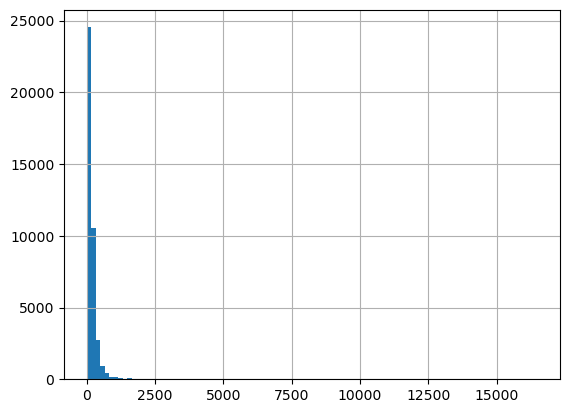

In [7]:
df_listings.price.hist(bins=100)

In [8]:
df_listings = df_listings[df_listings.price != 0]

In [9]:
df_listings['target'] = np.log(df_listings.price)

<AxesSubplot:>

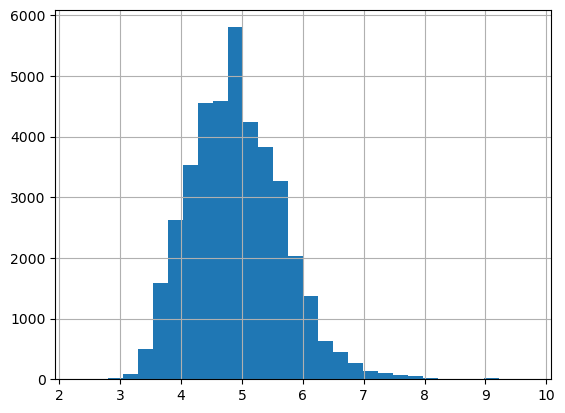

In [10]:
df_listings['target'].hist(bins=30)

# Define lists of columns to create features

In [11]:
raw_features = ["host_since", "host_about","host_response_time", 
                "host_response_rate", "host_acceptance_rate", "host_is_superhost", 
                "host_neighbourhood", "host_verifications", "host_listings_count", 
                "instant_bookable", "latitude", "longitude", "neighbourhood_cleansed",
                "neighbourhood_group_cleansed", "property_type", "room_type", 
                "accommodates", "bathrooms", "bathrooms_text", "bedrooms", "beds",
                "first_review", "last_review"]

In [12]:
df_listings[raw_features].head(5)

,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_verifications,host_listings_count,instant_bookable,latitude,longitude,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,first_review,last_review
0,2008-09-07,Educated professional living in Brooklyn. I l...,within an hour,100%,90%,f,Gravesend,"['email', 'phone']",9.0,f,40.64529,-73.97238,Kensington,Brooklyn,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,2015-12-04,2018-10-19
1,2008-09-09,A New Yorker since (Phone number hidden by Air...,within a day,75%,23%,f,Midtown,"['email', 'phone', 'work_email']",6.0,f,40.75356,-73.98559,Midtown,Manhattan,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,2009-11-21,2022-06-21
2,2009-02-03,"I am an artist(painter, filmmaker) and curato...",within an hour,100%,100%,t,Bedford-Stuyvesant,"['email', 'phone']",2.0,f,40.68535,-73.95512,Bedford-Stuyvesant,Brooklyn,Private room in rental unit,Private room,2,NaN,NaN,1.0,1.0,2009-05-28,2019-12-02
3,2010-08-17,Father of two boys - 9 & 10.,within an hour,100%,19%,f,Ridgewood,"['email', 'phone']",7.0,f,40.70309,-73.89963,Ridgewood,Queens,Entire townhouse,Entire home/apt,16,NaN,2.5 baths,5.0,10.0,2012-01-03,2019-11-12
4,2009-02-03,"Rebecca is an artist/designer, and Henoch is i...",NaN,NaN,33%,f,Greenwood Heights,"['email', 'phone']",1.0,f,40.66265,-73.99454,Sunset Park,Brooklyn,Entire rental unit,Entire home/apt,4,NaN,1.5 baths,2.0,2.0,2014-01-02,2022-08-10


# I need to complete these lists with the relevant columns

In [13]:
date_features = ["host_since", "first_review", "last_review"]
numeric_features = ["host_response_rate", "host_acceptance_rate", "host_is_superhost", 
                   "host_listings_count", "instant_bookable", 
                   "latitude", "longitude", "accommodates", "bedrooms", "beds", "bathrooms_text"]
categorical_features = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
                        'property_type', 'room_type']

# Feature engineering - Numeric Variables

In [14]:
df_listings['host_response_rate'] = df_listings.host_response_rate.str.replace("%", "").astype("float32")

In [15]:
df_listings['host_acceptance_rate'] = df_listings.host_acceptance_rate.str.replace("%", "").astype("float32")

In [16]:
lkp_boolean = {"t":1, "f":0}
df_listings['host_is_superhost'] = df_listings.host_is_superhost.map(lkp_boolean)

In [17]:
df_listings['instant_bookable'] = df_listings.instant_bookable.map(lkp_boolean)

In [18]:
def test_shared_bath(x):
    if "shared" in str(x):
        return 1
    else:
        return 0

In [19]:
df_listings['shared_bathrooms'] = df_listings.bathrooms_text.apply(test_shared_bath)

In [20]:
def get_nbr_bathrooms(x):
    if x is np.NaN:
        return 0
    elif "half-bath" in x.lower():
        return 0.5
    else:
        return float(x.split(" ")[0])

In [21]:
get_nbr_bathrooms("1 shared bath")

1.0

In [22]:
df_listings['nbr_bathrooms'] = df_listings.bathrooms_text.apply(get_nbr_bathrooms)

In [23]:
df_listings['host_lives_nbh'] = (df_listings.host_neighbourhood == df_listings.neighbourhood_cleansed).astype("int8")

In [24]:
date_features = ["host_since", "first_review", "last_review"]
numeric_features = ["host_response_rate", "host_acceptance_rate", "host_is_superhost", 
                   "host_listings_count", "instant_bookable", 
                   "latitude", "longitude", "accommodates", "bedrooms", "beds", 
                    "nbr_bathrooms", "shared_bathrooms", "host_lives_nbh"]
categorical_features = ["host_response_time", "neighbourhood_group_cleansed", 
                        "neighbourhood_cleansed", "property_type", "room_type"]

In [25]:
df_listings[numeric_features].dtypes

host_response_rate      float32
host_acceptance_rate    float32
host_is_superhost         int64
host_listings_count     float64
instant_bookable          int64
latitude                float64
longitude               float64
accommodates              int64
bedrooms                float64
beds                    float64
nbr_bathrooms           float64
shared_bathrooms          int64
host_lives_nbh             int8
dtype: object

# Feature engineering - Categorical variables

In [26]:
df_listings[categorical_features].head()

,host_response_time,neighbourhood_group_cleansed,neighbourhood_cleansed,property_type,room_type
0,within an hour,Brooklyn,Kensington,Private room in rental unit,Private room
1,within a day,Manhattan,Midtown,Entire rental unit,Entire home/apt
2,within an hour,Brooklyn,Bedford-Stuyvesant,Private room in rental unit,Private room
3,within an hour,Queens,Ridgewood,Entire townhouse,Entire home/apt
4,NaN,Brooklyn,Sunset Park,Entire rental unit,Entire home/apt


In [27]:
df_listings.host_response_time.value_counts()

within an hour        16401
within a few hours     5628
within a day           3472
a few days or more      813
Name: host_response_time, dtype: int64

In [28]:
host_response_time_lkp = {'within an hour':"hour", 
                          'within a day':"one_day", 
                          'within a few hours':"few_hours", 
                          'a few days or more':"few_days"}

In [29]:
df_listings['host_response_time'] = df_listings.host_response_time.map(host_response_time_lkp)

In [30]:
df_listings.neighbourhood_cleansed.value_counts()

Bedford-Stuyvesant    2778
Williamsburg          2453
Harlem                1878
Midtown               1694
Bushwick              1657
                      ... 
Hollis Hills             1
Woodrow                  1
Westerleigh              1
Country Club             1
Bull's Head              1
Name: neighbourhood_cleansed, Length: 244, dtype: int64

In [31]:
df_listings.property_type.value_counts().nlargest(10)

Entire rental unit             16842
Private room in rental unit    10489
Private room in home            2132
Entire condo                    1642
Entire home                     1476
Private room in townhouse       1065
Entire loft                      746
Room in hotel                    665
Entire townhouse                 659
Entire serviced apartment        614
Name: property_type, dtype: int64

In [32]:
df_listings.room_type.value_counts()

Entire home/apt    22761
Private room       16361
Shared room          557
Hotel room           172
Name: room_type, dtype: int64

In [33]:
s = df_listings.host_verifications.head(1).values[0]

In [34]:
s

"['email', 'phone']"

In [35]:
import ast

In [36]:
len(ast.literal_eval(s))

2

In [37]:
def count_verification_methods(x):
    x = ast.literal_eval(x)
    if x is not None:
        return len(x)
    else:
        return 0

In [38]:
count_verification_methods(s)

2

In [39]:
df_listings['nbr_host_verifications'] = df_listings.host_verifications.apply(count_verification_methods)

In [40]:
df_listings[categorical_features].nunique().sum()

336

# Feature engineering - Date variables

In [ ]:
date_features = ["host_since", "first_review", "last_review"]
numeric_features = ["host_response_rate", "host_acceptance_rate", "host_is_superhost", 
                   "host_listings_count", "instant_bookable", 
                   "latitude", "longitude", "accommodates", "bedrooms", "beds", 
                    "nbr_bathrooms", "shared_bathrooms", "host_lives_nbh", 
                   "nbr_host_verifications"]
categorical_features = ["host_response_time", "neighbourhood_group_cleansed", 
                        "neighbourhood_cleansed", "property_type", "room_type"]

In [ ]:
df_listings[date_features].head()

In [ ]:
todays_date = pd.to_datetime("2022-11-20")
todays_date

In [ ]:
df_listings[date_features].dtypes

In [ ]:
pd.to_datetime("2008-09-07")

In [ ]:
df_listings['days_since_host'] = (todays_date - pd.to_datetime(df_listings.host_since)).dt.days
df_listings['days_since_first_review'] = (todays_date - pd.to_datetime(df_listings.first_review)).dt.days
df_listings['days_since_last_review'] = (todays_date - pd.to_datetime(df_listings.last_review)).dt.days

In [ ]:
numeric_features = ["host_response_rate", "host_acceptance_rate", "host_is_superhost", 
                   "host_listings_count", "instant_bookable", 
                   "latitude", "longitude", "accommodates", "bedrooms", "beds", 
                    "nbr_bathrooms", "shared_bathrooms", "host_lives_nbh", 
                   "nbr_host_verifications", "days_since_host", 
                   "days_since_first_review", "days_since_last_review"]

categorical_features = ["host_response_time", "neighbourhood_group_cleansed", 
                        "neighbourhood_cleansed", "property_type", "room_type"]